# Template for analyzing the CLM5-PPE
- Updated August 11, 2021
- Daniel Kennedy, djk2120@ucar.edu

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm

## spin up some extra cores on CASPER

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    client = Client(cluster)
    return cluster, client

In [3]:
#only run once
cluster, client = get_ClusterClient()
cluster.scale(20)

In [12]:
#note that you should eventually see your workers in the output here
# you can rerun this cell, to check that the job made it through the queue
client

Client Scheduler: tcp://10.12.206.54:41115 Dashboard: https://https://jupyterhub.hpc.ucar.edu/stable/user/djk2120/proxy/{port}/status,Cluster Workers: 20 Cores: 20 Memory: 500.00 GB


## A few useful functions

In [13]:
def get_params(keys,paramkey):
    params=[]
    minmaxs=[]
    for key in keys:
        ix     = paramkey.key==key
        params.append(paramkey.param[ix].values[0])
        minmaxs.append(paramkey.minmax[ix].values[0])
    return params,minmaxs

In [14]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [15]:
def find_pair(da,params,minmax,p):
    '''
    returns a subset of da, corresponding to parameter-p
        the returned pair corresponds to [p_min,p_max]
    '''
    ixmin = np.logical_and(params==p,minmax=='min')
    ixmax = np.logical_and(params==p,minmax=='max')
    
    #sub in default if either is missing
    if ixmin.sum().values==0:
        ixmin = params=='default'
    if ixmax.sum().values==0:
        ixmax = params=='default'
        
    emin = da.ens.isel(ens=ixmin).values[0]
    emax = da.ens.isel(ens=ixmax).values[0]

    return da.sel(ens=[emin,emax])

In [16]:
def param_effect(ds,datavar,cf,uniques):
    
    if type(uniques)==str:
        uniques = [uniques]
    
    #reduce datavar to global, annual values
    x    = ds[datavar]
    xann = cf*(month_wts(10)*(la*x).sum(dim='gridcell')).groupby('time.year').sum().compute()
    
    #pair the simulations by parameter
    #  and calculate the param effect on mean and IAV
    xmeans  = []; xiavs   = []
    for u in uniques:
        pair  = find_pair(xann,ds.param,ds.minmax,u)
        xmean = pair.mean(dim='year').values
        xiav  = pair.std(dim='year').values

        xmeans.append(xmean)
        xiavs.append(xiav)

    return xmeans,xiavs,xann

In [17]:
def get_map(da):
    '''
    Regrid from sparsegrid to standard lat/lon
    
    Better to do any dimension-reducing math before calling this function. 
    Could otherwise be pretty slow...
    '''
    
    #ACCESS the sparsegrid info
    thedir  = '/glade/u/home/forrest/ppe_representativeness/output_v4/'
    thefile = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
    sg = xr.open_dataset(thedir+thefile)
    
    #DIAGNOSE the shape of the output map
    newshape = []
    coords=[]
    #  grab any dimensions that arent "gridcell" from da
    for coord,nx in zip(da.coords,da.shape):
        if nx!=400:
            newshape.append(nx)
            coords.append((coord,da[coord]))
    #  grab lat/lon from sg
    for coord in ['lat','lon']:
        nx = len(sg[coord])
        newshape.append(nx)
        coords.append((coord,sg[coord]))

    #INSTANTIATE the outgoing array
    array = np.zeros(newshape)+np.nan
    nd    = len(array.shape)
    
    #FILL the array
    ds = xr.open_dataset('/glade/scratch/djk2120/PPEn11/hist/CTL2010/PPEn11_CTL2010_OAAT0399.clm2.h0.2005-02-01-00000.nc')
    for i in range(400):
        lat=ds.grid1d_lat[i]
        lon=ds.grid1d_lon[i]
        cc = sg.rcent.sel(lat=lat,lon=lon,method='nearest')
        ix = sg.cclass==cc
        
        
        if nd==2:
            array[ix]=da.isel(gridcell=i)
        else:
            nx = ix.sum().values
            array[:,ix]=np.tile(da.isel(gridcell=i).values[:,np.newaxis],[1,nx])
    
    #OUTPUT as DataArray
    da_map = xr.DataArray(array,name=da.name,coords=coords)
    da_map.attrs=da.attrs

    return da_map

In [21]:
def get_ensemble(name,data_vars,htape,keys,paramkey):
    '''
    Returns a dataset comprising the given ensemble
    name  = 'CTL2020' or 'C285' or 'AF1905'
    data_vars, e.g. ['GPP','HR','AR']
    htape, e.g. 'h0' 0/1/2/3/4/5/7 available
    '''
    
    #define the directory structure and find files
    topdir     = '/glade/scratch/djk2120/PPEn11/hist/' 
    thisdir    = topdir+name+'/'
    files      = [glob.glob(thisdir+'*'+key+'*'+htape+'*.nc')[0] for key in keys]

    def preprocess(ds):
        return ds[data_vars]

    #read in the dataset
    ds = xr.open_mfdataset(files,combine='nested',concat_dim='ens',parallel=True,preprocess=preprocess)

    #fix up time dimension
    ds['time'] = xr.cftime_range(str(2005),periods=120,freq='MS') #fix time bug
    
    #add in some extra variables
    ds0 = xr.open_dataset(files[0])
    extras = ['grid1d_lat','grid1d_lon']
    for extra in extras:
        ds[extra]=ds0[extra]

    #append some info about key/param/minmax
    params,minmaxs = get_params(keys,paramkey) 
    ds['key']    = xr.DataArray(keys,dims='ens')
    ds['param']  = xr.DataArray(params,dims='ens')
    ds['minmax'] = xr.DataArray(minmaxs,dims='ens')
    
    return ds


## START HERE:

In [19]:
#fetch the paraminfo
csv = '/glade/scratch/djk2120/PPEn11/firstpass.csv' 
paramkey = pd.read_csv(csv)

#fetch the sparsegrid landarea
la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
la = xr.open_dataset(la_file).landarea  #km2

In [22]:
## read in the CTL ensembles
keys = paramkey.key.values
name = 'CTL2010'
data_vars = ['GPP','HR','AR']
htape = 'h0'
ds = get_ensemble(name,data_vars,htape,keys,paramkey)

In [23]:
ds.GPP

<xarray.DataArray 'GPP' (ens: 373, time: 120, gridcell: 400)>
dask.array<concatenate, shape=(373, 120, 400), dtype=float32, chunksize=(1, 120, 400), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00
Dimensions without coordinates: ens, gridcell
Attributes:
    long_name:     gross primary production
    units:         gC/m^2/s
    cell_methods:  time: mean

In [25]:
#use the landarea vector and month_wts to calculate average annual GPP
cf = 24*60*60*1e-9  #PgC
gpp_glob     = (la*ds.GPP).sum(dim='gridcell')
gpp_glob_ann = cf*(month_wts(10)*gpp_glob).groupby('time.year').sum()
gpp_avg      = gpp_glob_ann.mean(dim='year').compute()

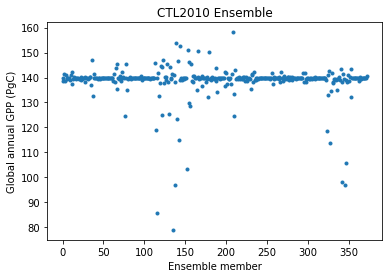

In [26]:
gpp_avg.plot.line('.')
plt.xlabel('Ensemble member')
plt.ylabel('Global annual GPP (PgC)')
plt.title(name+' Ensemble');

In [27]:
#which perturbations yield the bottom 10 lowest GPP?
print('LOW GPP:')
for i in np.argsort(gpp_avg)[:10]:
    p = str(ds.param[i].values)
    m = str(ds.minmax[i].values)
    print('   '+p+'-'+m)

LOW GPP:
   lmrse-max
   medlynintercept-max
   jmaxb0-min
   vcmaxse_sf-max
   lmrhd-min
   kmax-min
   jmaxse_sf-max
   tpuha-max
   wc2wjb0-min
   vcmaxha-max


### look at the map of jmaxb0-min

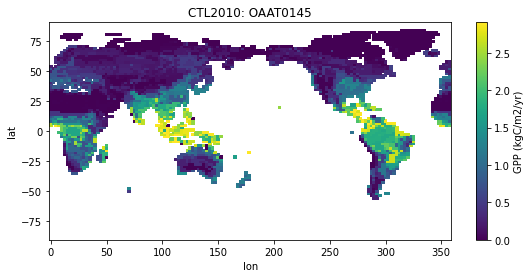

In [29]:
#find the given member
ix  = np.logical_and(ds.param=='jmaxb0',ds.minmax=='min')
da  = ds.GPP.isel(ens=ix) 

#calc annual gpp
nyrs = 10
cf   = 24*60*60/nyrs/1000
gpp  = cf*(month_wts(nyrs)*da).sum(dim='time').compute() #kgC/m2/yr

#convert to map
gpp_map = get_map(gpp)

#plot
plt.figure(figsize=[9,4])
gpp_map.plot(cbar_kwargs={'label':'GPP (kgC/m2/yr)'})
plt.title(name+': '+str(ds.key.isel(ens=ix).values[0]));

### calculate parameter effect
- i.e. max perturb -  min perturb

In [38]:
##this is used below
def plot_top20(xvals,ranks,xdef,datavar,op,units):
    plt.plot([xdef,xdef],[-1,-20],'k:',label='default')
    for i in range(-1,-21,-1):
        j = ranks[i]
        x = xvals[j]
        
        plt.scatter(x[0],i,marker='o',facecolors='none', edgecolors='r',label='low-val')
        plt.scatter(x[1],i,color='r',marker='o',label='high-val')
        if (i==-1):
            plt.legend(loc=3)
        plt.plot([x.min(),x.max()],[i,i],'-r')

    plt.xlabel(datavar+'_'+op+' ('+units+')')
    plt.title(datavar+'_'+op)
    pticks = [uniques[ranks[i]] for i in range(-1,-21,-1)]
    plt.yticks(range(-1,-21,-1),pticks)

In [43]:
#some useful conversion factors/units
cfs = dict()
units = dict()

#fluxes [summed, extensive variable]
for field in ['GPP','HR','AR','NPP','NBP','COL_FIRE_CLOSS']:
    cfs[field]   = 1e-9*24*60*60
    units[field] = 'PgC/yr'
for field in ['FCTR','FCEV','FGEV','EFLX_LH_TOT']:
    cfs[field]   = 1/2.5e6*1e-9*24*60*60
    units[field] = 'TtH2O/yr'
for field in ['QHR','QVEGT']:
    cfs[field]   = 1e-9*24*60*60
    units[field] = 'TtH2O/yr'
    
#FAREA [summed, extensive variable]
cfs['FAREA_BURNED']=24*60*60/1e6
units['FAREA_BURNED']='1e6km2'
    
#pools [averaged, extensive variable]
for field in ['TWS','SOILWATER_10CM']:
    cfs[field]   = 1e-9/365
    units[field] = 'TtH2O'
for field in ['TOTVEGC','TOTSOMC_1m']:
    cfs[field]   = 1e-9/365
    units[field] = 'PgC'
    
#intensives (need to account for landarea)
lasum = la.sum().values
for field in ['SNOWDP','TV','TSOI_10CM','TLAI','FSR','FSH']:
    cfs[field]   = 1/la.sum()/365
    if field in ds.data_vars:
        units[field] = ds[field].attrs['units']
    else:
        units[field] = 'TBD'

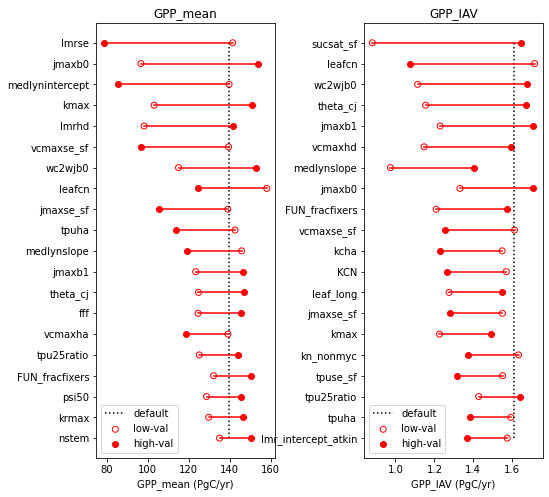

In [41]:
datavar = 'GPP'
cf = cfs[datavar]      #conversion factor
unit = units[datavar]
uniques = np.unique(ds.param)

#calculate annual mean and IAV for the given datavar
#    xmeans is a list of paired means for [pmin,pmax] for each p in uniques
#    xmeans is a list of paired iavs  for [pmin,pmax] for each p in uniques
#    xann   is basically ds[datavar].groupby('time.year').mean()
xmeans,xiavs,xann = param_effect(ds,datavar,cf,uniques)

#calculate the ranges for mean and IAV
dmeans = [abs(xmean[0]-xmean[1]) for xmean in xmeans]
diavs  = [abs(xiav[0] -xiav[1])  for xiav  in xiavs]   

#rank the parameters
mean_ranks = np.argsort(dmeans)
mean_def   = xann.isel(ens=0).mean(dim='year')
iav_ranks  = np.argsort(diavs)
iav_def    = xann.isel(ens=0).std(dim='year')

#plot, defined above
plt.figure(figsize=[8,8])
plt.subplot(121)
plot_top20(xmeans,mean_ranks,mean_def,datavar,'mean',unit)
plt.subplot(122)
plot_top20(xiavs,iav_ranks,iav_def,datavar,'IAV',unit)
plt.subplots_adjust(wspace=0.5)
